# LSTM Model Testing Notebook

This notebook demonstrates a modular testing framework for an LSTM model. The code loads a dataset, preprocesses it, creates sequences, loads a trained model, makes predictions, and evaluates the performance using accuracy, a classification report, and a confusion matrix.

You can modify the paths and parameters to test on different datasets (e.g., the 2018 dataset, simulation team dataset) without changing the core code.

In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

## Global Parameters & Paths

Update these paths as needed to point to the correct dataset, scaler, and model files. You can also change the sample size (set to `None` to use the full dataset).

In [31]:
# ----- Global Parameters & Paths -----

# Update these paths as needed.
DATASET_PATH = r"C:\Users\mrroo\Desktop\RP3\datasets\2019_reduced_valuable.csv"  # Using 2018 dataset for testing bug fixes.
SCALER_PATH = r"C:\Users\mrroo\Desktop\RP3\Imp\Outputs\LSTM\2019\lstm_run1-100percent-postseq\scaler.pkl"
LSTM_MODEL_PATH = r"C:\Users\mrroo\Desktop\RP3\Imp\Outputs\LSTM\2019\lstm_run1-100percent-postseq\lstm_model.keras"
WINDOW_SIZE = 10  # Same as used during training.

# The features used for prediction (do not include the target column).
SELECTED_FEATURES = [
    'Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 
    'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 
    'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 
    'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 
    'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min'
]

# Name of the target column in the dataset.
TARGET_COLUMN = "label"

# Optionally, set a sample size. Set to None to use the full dataset. {20%, 50%, 100%}
SAMPLE_SIZE = 20

## Function Definitions

The following functions cover data loading, sampling, preprocessing, sequence creation, model loading, prediction, and evaluation.

In [32]:
def load_data(file_path, features, target_column=None):
    """
    Loads a CSV dataset. If a target_column is provided, returns both features (X) and targets (y);
    otherwise, returns only the features.
    Drops rows with missing values in the selected features.
    """
    df = pd.read_csv(file_path)
    print(f"Data loaded from {file_path}. Shape: {df.shape}")
    df = df.dropna(subset=features + ([target_column] if target_column else []))
    if target_column:
        X = df[features]
        y = df[target_column]
        return X, y
    else:
        X = df[features]
        return X


def select_contiguous_sample(X, y=None, sample_percentage=SAMPLE_SIZE):
    """
    Selects a contiguous block of rows from the dataset based on a percentage,
    preserving the temporal order.
    
    Parameters:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series, optional): Target variable.
        sample_percentage (float): Percentage of rows to sample.
    
    Returns:
        If y is provided, returns (sampled_features, sampled_targets).
        Otherwise, returns the sampled features DataFrame.
    """
    n = int(len(X) * sample_percentage / 100)
    start_idx = np.random.randint(0, len(X) - n)
    end_idx = start_idx + n
    if y is not None:
        sample_df = X.iloc[start_idx:end_idx].copy()
        sample_df[TARGET_COLUMN] = y.iloc[start_idx:end_idx].values
        return sample_df[SELECTED_FEATURES], sample_df[TARGET_COLUMN]
    else:
        return X.iloc[start_idx:end_idx]



def select_sample_indices(total_sequences, sample_percentage=SAMPLE_SIZE, random_state=42):
    """
    Randomly selects indices from the available sequences.
    """
    np.random.seed(random_state)
    if sample_percentage is None or sample_percentage >= 100:
        return np.arange(total_sequences)
    n = int(total_sequences * sample_percentage / 100)
    indices = np.random.choice(total_sequences, n, replace=False)
    return np.sort(indices)  # preserve order

def preprocess_data(X, scaler_path):
    """
    Loads the saved scaler, ensures the expected features are present,
    and applies scaling.
    """
    scaler = joblib.load(scaler_path)
    expected_features = scaler.feature_names_in_
    missing_cols = set(expected_features) - set(X.columns)
    if missing_cols:
        print(f"Adding missing columns with default value 0: {missing_cols}")
        for col in missing_cols:
            X[col] = 0
    X = X[expected_features]
    return scaler.transform(X)



# def create_sequences_and_labels(X_scaled, y, timesteps):
#     """
#     Converts the scaled data into overlapping sequences for LSTM input.
#     Also aligns each sequence with a label (using the last row in the sequence).
    
#     Parameters:
#         X_scaled (np.array): Scaled feature data.
#         y (pd.Series or np.array): Ground truth labels.
#         timesteps (int): The window size used during training.
        
#     Returns:
#         sequences (np.array): Array of sequences shaped as (num_sequences, timesteps, num_features).
#         seq_labels (list): List of labels corresponding to each sequence.
#     """
#     sequences = []
#     seq_labels = []
#     y_array = np.array(y)
#     for i in range(len(X_scaled) - timesteps + 1):
#         sequences.append(X_scaled[i:i + timesteps])
#         # Using the label from the last timestep as the sequence label.
#         seq_labels.append(y_array[i + timesteps - 1])
#     return np.array(sequences), np.array(seq_labels)


def load_trained_model(model_path):
    """
    Loads and returns the trained LSTM model.
    """
    model = load_model(model_path)
    print("LSTM model loaded successfully.")
    return model


def predict_classes(model, sequences, label_mapping=None):
    """
    Uses the loaded model to predict class probabilities and then assigns class labels.
    
    If label_mapping is provided, the numeric predictions are mapped to human-readable labels.
    Otherwise, numeric indices are returned.
    """
    predictions = model.predict(sequences)
    predicted_classes = np.argmax(predictions, axis=1)
    if label_mapping:
        predicted_labels = [label_mapping.get(cls, str(cls)) for cls in predicted_classes]
    else:
        predicted_labels = predicted_classes
    return predicted_labels


def generate_label_mapping(y):
    """
    Generates a mapping from numeric indices to label names based on the unique values in y.
    Assumes that the order of unique values corresponds to the model's output order.
    """
    unique_labels = sorted(y.unique())
    mapping = {i: label for i, label in enumerate(unique_labels)}
    print("Generated label mapping:", mapping)
    return mapping

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix with given class names.
    
    Parameters:
        cm (np.array): Confusion matrix.
        classes (list): List of class names.
        title (str): Title for the plot.
        cmap: Color map (default: plt.cm.Blues).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def testing_sequence_generator(X, y, timesteps, indices, batch_size):
    """
    Generator that yields batches of sequences and corresponding labels,
    based on the provided indices.
    """
    total = len(indices)
    for i in range(0, total, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = []
        batch_y = []
        for j in batch_indices:
            if j + timesteps <= len(X):
                batch_X.append(X[j:j+timesteps])
                batch_y.append(y[j+timesteps-1])
        if batch_X:
            yield np.array(batch_X), np.array(batch_y)


def run_test(dataset_path, scaler_path, model_path, window_size, features, target_column,
             sample_percentage=None, sampling_method="contiguous"):
    """
    Runs the testing pipeline:
      1. Loads the dataset.
      2. Generates a label mapping.
      3. Optionally samples the dataset.
      4. Preprocesses the features.
      5. Instead of building all sequences in memory, uses a generator to iterate over sequences.
      6. Loads the trained model, makes predictions, and computes evaluation metrics.
    """
    # 1. Load dataset
    X_full, y_full = load_data(dataset_path, features, target_column)
    full_label_mapping = generate_label_mapping(y_full)
    
    # 2. Sampling raw data if desired (default: use full dataset)
    if sample_percentage is not None:
        if sampling_method == "contiguous":
            print(f"Selecting a contiguous block of {sample_percentage}% from the full dataset.")
            X, y = select_contiguous_sample(X_full, y_full, sample_percentage=sample_percentage)
        elif sampling_method == "post_sequence":
            print(f"Using full dataset for sequence creation, then selecting {sample_percentage}% of sequences.")
            X, y = X_full, y_full
        else:
            X, y = X_full, y_full
    else:
        X, y = X_full, y_full

    # 3. Preprocess features
    X_scaled = preprocess_data(X, scaler_path)
    
    # 4. Determine total number of valid sequences
    total_sequences = len(X_scaled) - window_size + 1
    print(f"Total possible sequences: {total_sequences}")
    
    # 5. Sample sequence indices if sample_percentage is provided
    indices = select_sample_indices(total_sequences, sample_percentage=sample_percentage)
    print(f"Using {len(indices)} sequences for testing.")
    
    # 6. Create a generator for testing sequences
    test_batch_size = 128
    test_gen = testing_sequence_generator(X_scaled, y, window_size, indices, test_batch_size)
    steps = (len(indices) + test_batch_size - 1) // test_batch_size
    
    # 7. Load the trained model
    model = load_trained_model(model_path)
    
     # 8. Iterate over the generator to collect predictions and true labels
    all_predictions = []
    all_true = []
    for batch_X, batch_y in test_gen:
        preds = model.predict(batch_X)
        predicted_classes = np.argmax(preds, axis=1)
        all_predictions.extend(predicted_classes)
        all_true.extend(batch_y)
    all_predictions = np.array(all_predictions)
    all_true = np.array(all_true)
    
    # Convert numeric predictions to string labels using full_label_mapping
    all_predictions_str = [full_label_mapping[int(p)] for p in all_predictions]
    
    # Now both all_true and all_predictions_str are strings, so we can evaluate
    print("\nEvaluation Metrics:")
    acc = accuracy_score(all_true, all_predictions_str)
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(all_true, all_predictions_str))
    
    cm = confusion_matrix(all_true, all_predictions_str)
    print("\nConfusion Matrix:")
    print(cm)
    classes = [full_label_mapping[i] for i in range(len(full_label_mapping))]
    plot_confusion_matrix(cm, classes)
    
    print("\nSample predictions (first 20 sequences):")
    print(all_predictions_str[:20])






## Run the Testing Pipeline

The cell below executes the testing pipeline using the provided parameters. Modify the `SAMPLE_SIZE` variable to change the sample size, or set it to `None` to use the full dataset.

Data loaded from C:\Users\mrroo\Desktop\RP3\datasets\2019_reduced_valuable.csv. Shape: (19231509, 32)
Generated label mapping: {0: 'BENIGN', 1: 'DrDoS_DNS', 2: 'DrDoS_LDAP', 3: 'DrDoS_MSSQL', 4: 'DrDoS_NTP', 5: 'DrDoS_NetBIOS', 6: 'DrDoS_SNMP', 7: 'DrDoS_SSDP', 8: 'DrDoS_UDP', 9: 'Syn', 10: 'TFTP', 11: 'UDP-lag', 12: 'WebDDoS'}
Using full dataset for sequence creation, then selecting 20% of sequences.
Adding missing columns with default value 0: {'Bwd IAT Max', 'Bwd IAT Mean', 'Flow Bytes/s', 'Bwd IAT Min', 'Bwd IAT Tot', 'Flow Packets/s'}
Total possible sequences: 19231500
Using 3846300 sequences for testing.
LSTM model loaded successfully.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━

c:\Users\mrroo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mrroo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mrroo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

               precision    recall  f1-score   support

       BENIGN       1.00      1.00      1.00      9974
    DrDoS_DNS       0.00      0.00      0.00    600364
   DrDoS_LDAP       0.00      0.00      0.00    282680
  DrDoS_MSSQL       0.00      0.00      0.00    541566
    DrDoS_NTP       0.00      0.00      0.00    222824
DrDoS_NetBIOS       0.00      0.00      0.00    566649
   DrDoS_SNMP       0.00      0.00      0.00    605924
   DrDoS_SSDP       1.00      1.00      1.00    400088
    DrDoS_UDP       0.56      1.00      0.72    425198
          Syn       0.00      0.00      0.00     25666
         TFTP       0.00      0.00      0.00    149752
      UDP-lag       0.00      0.00      0.00     15308
      WebDDoS       0.00      0.00      0.00       307

     accuracy                           0.22   3846300
    macro avg       0.20      0.23      0.21   3846300
 weighted avg       0.17      0.22      0.19   3846300


Confusion Matrix:
[[  9968      0      1      1      0      0

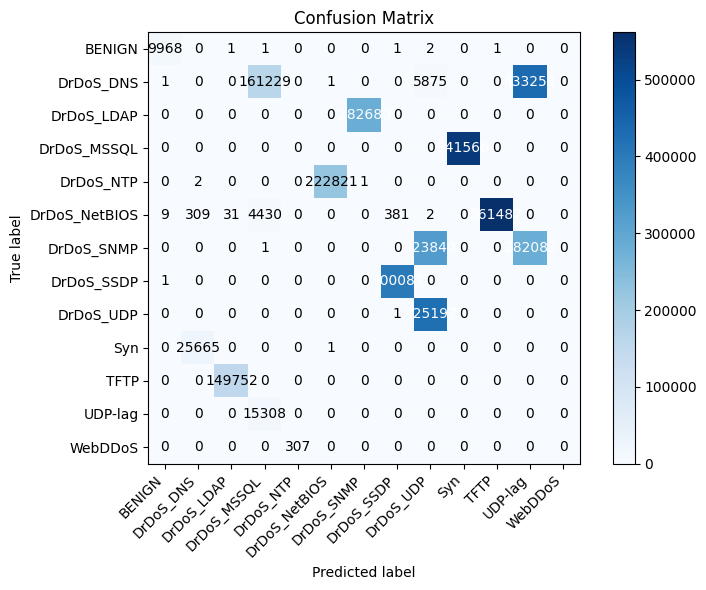


Sample predictions (first 20 sequences):
['BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN']


In [33]:
## Run the Testing Pipeline

if __name__ == "__main__":
    run_test(
        dataset_path=DATASET_PATH,
        scaler_path=SCALER_PATH,
        model_path=LSTM_MODEL_PATH,
        window_size=WINDOW_SIZE,
        features=SELECTED_FEATURES,
        target_column=TARGET_COLUMN,
        sample_percentage=SAMPLE_SIZE,  # Percentage of sequences to sample
        sampling_method="post_sequence"  # "contiguous" or "post_sequence"
    )
    

In [35]:

# Base output folder path
base_output_folder = r"C:\Users\mrroo\Desktop\RP3\test\outputs"

# Specify a unique run name (change this for each run)
model_name = "LSTM-smol"  # Change as desired

run_name = "test1-20per-2019smol"  # Change as desired

# Combine the base folder with the run name to create a subfolder
output_folder = os.path.join(base_output_folder, model_name, run_name)

# Create the subfolder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

print("Output folder for this run:", output_folder)
# Create a results folder inside the output_folder if not exists
results_folder = os.path.join(output_folder, "evaluation_results")
os.makedirs(results_folder, exist_ok=True)

# 1. Save overall accuracy and classification report to a text file.
results_text_path = os.path.join(results_folder, "evaluation_report.txt")
with open(results_text_path, "w") as f:
    f.write("Evaluation Metrics\n")
    f.write("==================\n\n")
    f.write("Overall Accuracy: {:.4f}\n\n".format(acc))
    f.write("Classification Report:\n")
    f.write(classification_report(all_true, all_predictions_str))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cm, separator=", "))
print("Evaluation report saved to:", results_text_path)

# 2. Save the confusion matrix to a CSV file.
cm_df = pd.DataFrame(cm, 
                     index=[full_label_mapping[i] for i in range(len(full_label_mapping))],
                     columns=[full_label_mapping[i] for i in range(len(full_label_mapping))])
cm_csv_path = os.path.join(results_folder, "confusion_matrix.csv")
cm_df.to_csv(cm_csv_path, index=True)
print("Confusion matrix saved to:", cm_csv_path)

# 3. Save the classification report as a CSV file.
# Parse the classification report into a dictionary, then into a DataFrame.
report_dict = classification_report(all_true, all_predictions_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_csv_path = os.path.join(results_folder, "classification_report.csv")
report_df.to_csv(report_csv_path, index=True)
print("Classification report saved to:", report_csv_path)

Output folder for this run: C:\Users\mrroo\Desktop\RP3\test\outputs\LSTM-smol\test1-20per-2019smol


NameError: name 'acc' is not defined